# # **Time-Series-Demand-Forecasting-for-Retail-Sales**  

---

## **Project Overview**  
This project focuses on **forecasting retail sales** using advanced **time series modeling techniques**.  
We analyze historical sales data, identify patterns like **trend** and **seasonality**, and build predictive models such as **Holt-Winters, ARIMA, and Prophet** to generate accurate forecasts.  
The goal is to help retailers optimize **inventory management**, **resource planning**, and **sales strategy** by predicting future demand.

---

## **1. Setup and Installation**
We start by installing and importing all the required libraries for data analysis, visualization, and time-series modeling.



In [ ]:


# ## 1. Setup and Installation
# ------------------------------------------------------------------------------
# Install necessary libraries quietly
#!pip install pmdarima -q

# Import all required libraries
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from prophet import Prophet

# Metrics and utilities
from sklearn.metrics import mean_squared_error
import logging

# Suppress verbose output from Prophet
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
# Set a consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Setup Complete: All libraries are installed and imported.")

✅ Setup Complete: All libraries are installed and imported.


In [ ]:
# ## 2. Data Loading and Cleaning
# ------------------------------------------------------------------------------
print("\n--- Loading and Cleaning Data ---")
try:
    data = pd.read_csv('demand.csv')
    print("Dataset 'demand.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'demand.csv' not found. Please upload the file to your Colab environment.")
    # Exit if the file is not found
    exit()

# Handle missing 'total_price' with the median price for that specific SKU
# This is a robust way to impute missing values without skewing the data
if data['total_price'].isnull().any():
    median_price_per_sku = data.groupby('sku_id')['total_price'].transform('median')
    data['total_price'].fillna(median_price_per_sku, inplace=True)
    print("Missing 'total_price' values filled using SKU-specific medians.")

# Convert 'week' column to datetime format for time series analysis
data['week'] = pd.to_datetime(data['week'], format='%d/%m/%y')

print(f"Data shape after cleaning: {data.shape}")
print(data.head())


--- Loading and Cleaning Data ---
Dataset 'demand.csv' loaded successfully.
Missing 'total_price' values filled using SKU-specific medians.
Data shape after cleaning: (150150, 9)
   record_ID       week  store_id  sku_id  total_price  base_price  \
0          1 2011-01-17      8091  216418      99.0375    111.8625   
1          2 2011-01-17      8091  216419      99.0375     99.0375   
2          3 2011-01-17      8091  216425     133.9500    133.9500   
3          4 2011-01-17      8091  216233     133.9500    133.9500   
4          5 2011-01-17      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  
0                0               0          20  
1                0               0          28  
2                0               0          19  
3                0               0          44  
4                0               0          52  



--- Starting Exploratory Data Analysis (EDA) ---

Plotting feature distributions...


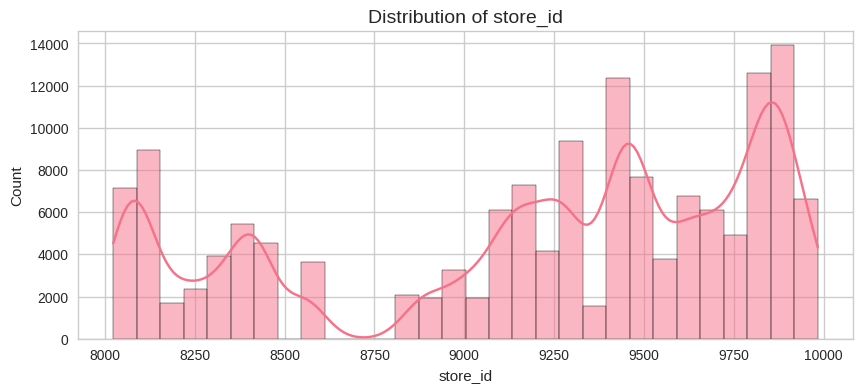

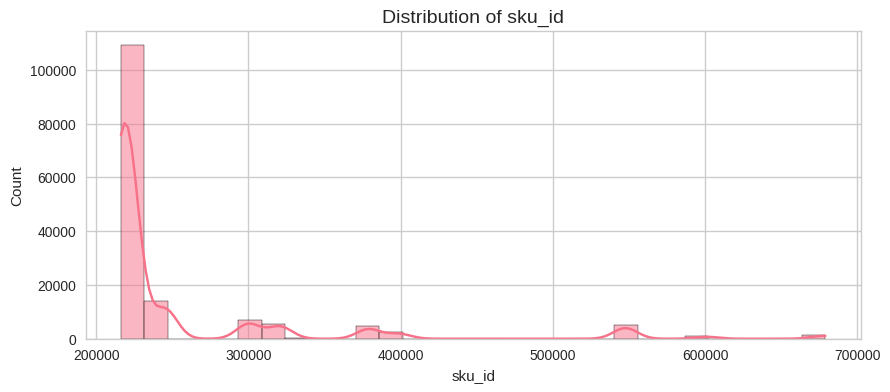

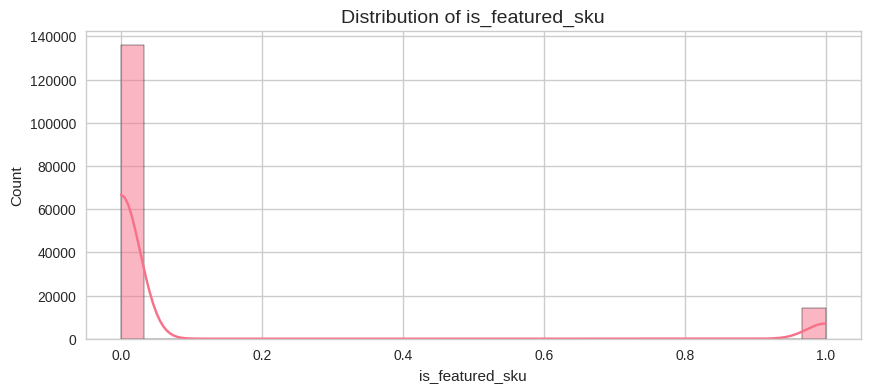

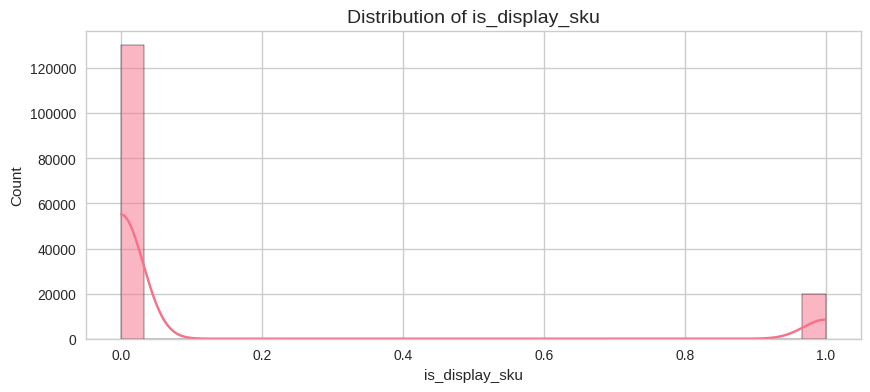

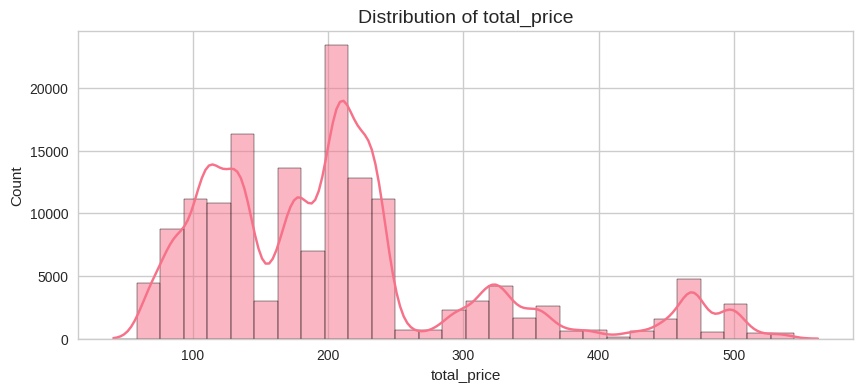

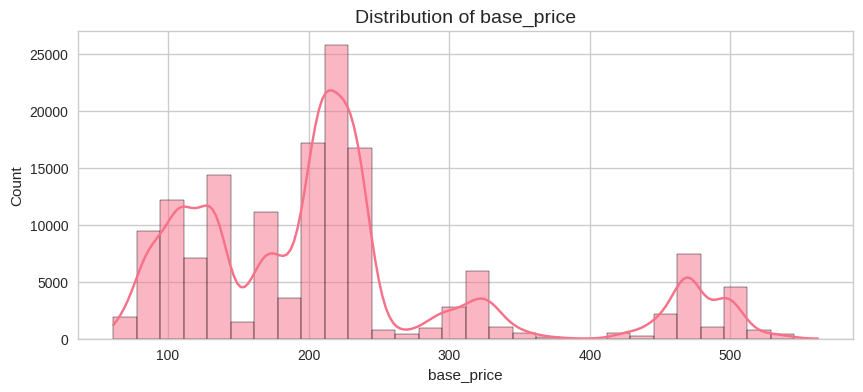

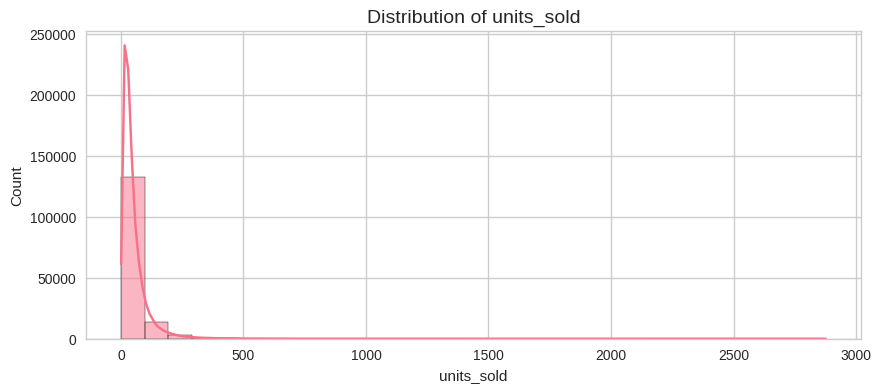

In [14]:
# ## 3. Exploratory Data Analysis (EDA)
# ------------------------------------------------------------------------------
print("\n--- Starting Exploratory Data Analysis (EDA) ---")

# --- 3.1. Feature Distributions ---
print("\nPlotting feature distributions...")
# Plot histograms for key categorical/numerical columns
dist_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'total_price', 'base_price', 'units_sold']
for col in dist_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()





Calculating and plotting feature correlation heatmap...


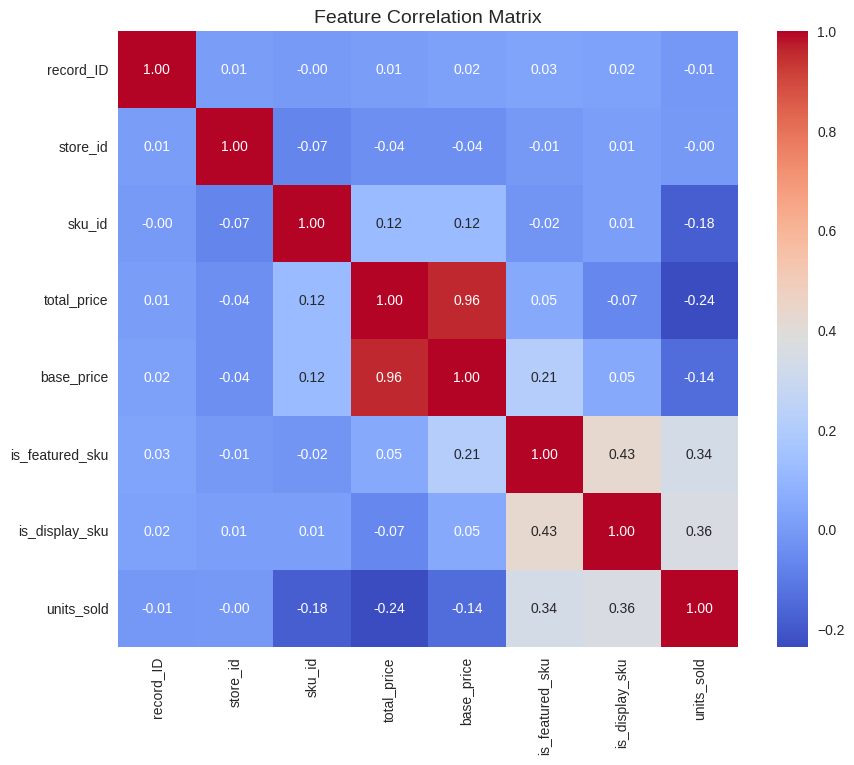

💡 EDA Insight: 'is_featured_sku' and 'is_display_sku' show a positive correlation with 'units_sold'. This suggests they are important predictors and should be included in our models.


In [15]:
# --- 3.2. Correlation Analysis ---
print("\nCalculating and plotting feature correlation heatmap...")
# We only correlate numerical columns
numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()
print("💡 EDA Insight: 'is_featured_sku' and 'is_display_sku' show a positive correlation with 'units_sold'. This suggests they are important predictors and should be included in our models.")



Performing initial time series analysis on total weekly sales...


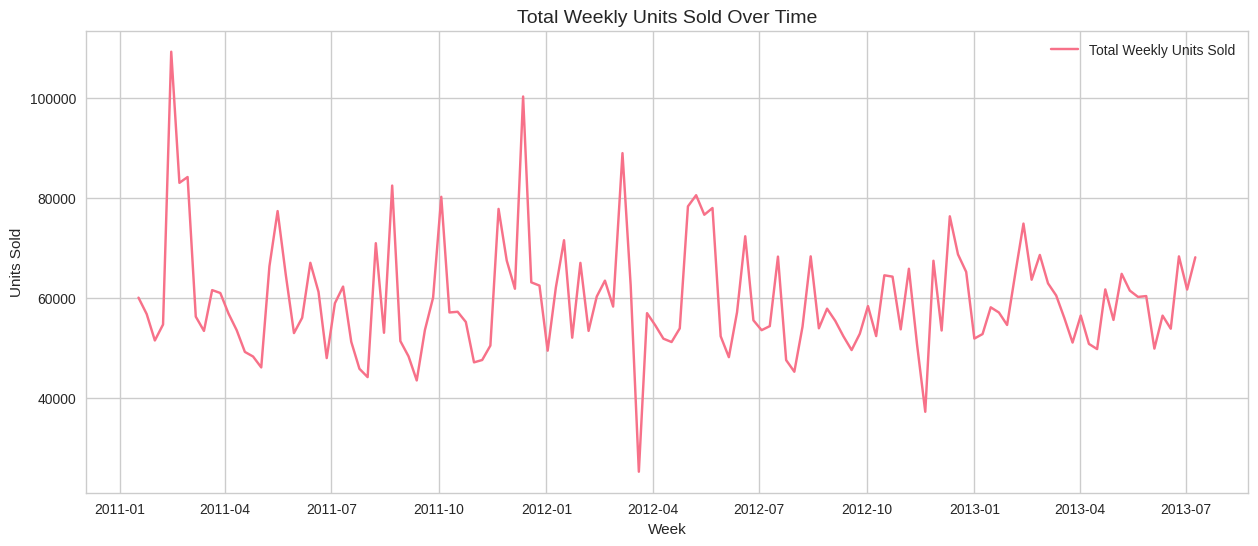

In [16]:



# --- 3.3. Time Series Analysis ---
print("\nPerforming initial time series analysis on total weekly sales...")
# Aggregate total units sold by week for an overview
weekly_sales = data.groupby('week')['units_sold'].sum().reset_index()
weekly_sales.set_index('week', inplace=True)

# Plot the aggregated time series
plt.figure(figsize=(15, 6))
plt.plot(weekly_sales.index, weekly_sales['units_sold'], label='Total Weekly Units Sold')
plt.title('Total Weekly Units Sold Over Time', fontsize=14)
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

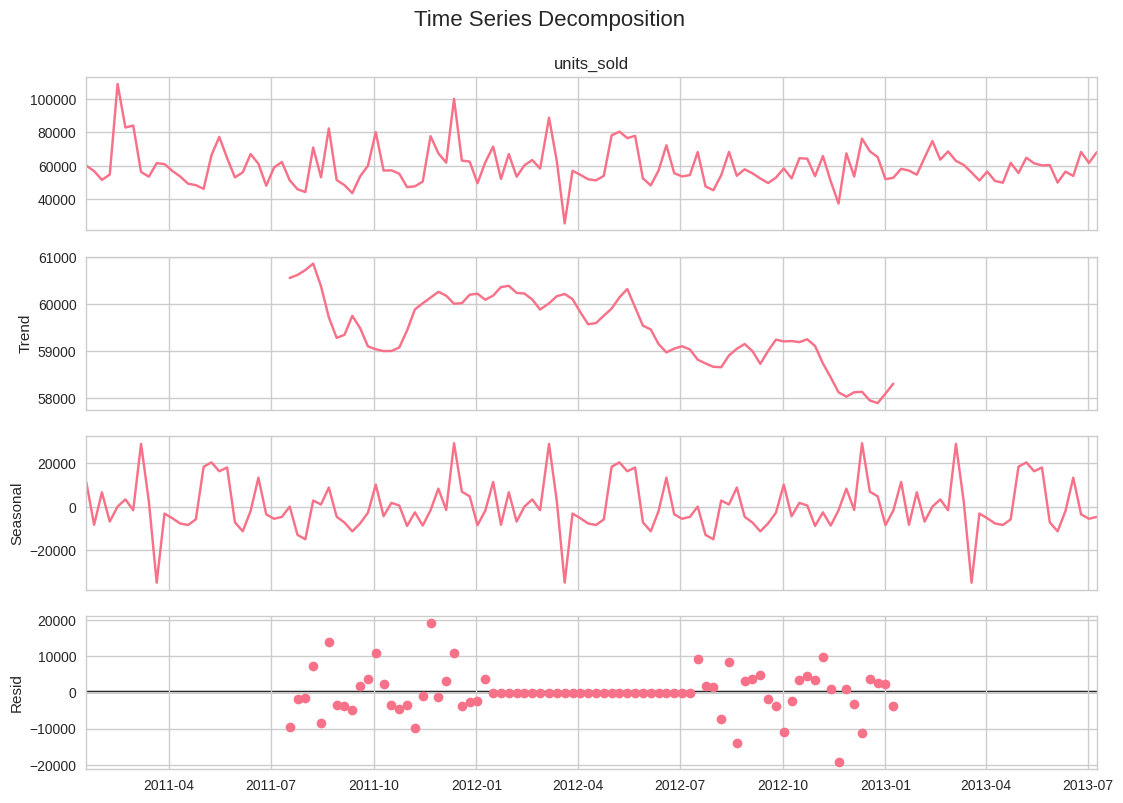

💡 EDA Insight: The decomposition clearly shows a yearly seasonal pattern with no strong long-term trend.


In [17]:


# Decompose the time series to see trend, seasonality, and residuals
decomposition = seasonal_decompose(weekly_sales['units_sold'], model='additive', period=52) # 52 weeks in a year
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition', y=1.02, fontsize=16)
plt.show()
print("💡 EDA Insight: The decomposition clearly shows a yearly seasonal pattern with no strong long-term trend.")

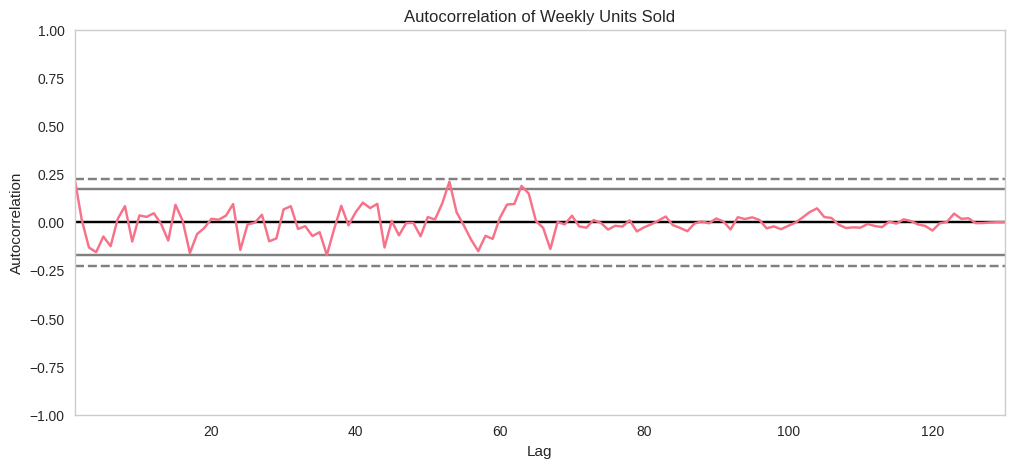

💡 EDA Insight: The wave-like pattern in the autocorrelation plot confirms strong yearly seasonality.


In [18]:

# Plot autocorrelation to confirm seasonality
plt.figure(figsize=(12, 5))
autocorrelation_plot(weekly_sales['units_sold'])
plt.title('Autocorrelation of Weekly Units Sold')
plt.show()
print("💡 EDA Insight: The wave-like pattern in the autocorrelation plot confirms strong yearly seasonality.")

In [11]:
# ## 4. Feature Engineering for Advanced Models
# ------------------------------------------------------------------------------
print("\n--- Engineering Features for Modeling ---")
# Based on EDA, we aggregate all potentially useful features weekly.
# This creates the dataset for our advanced models (ARIMAX and Prophet).
data.set_index('week', inplace=True)

aggregation_rules = {
    'units_sold': 'sum',      # Target variable (y)
    'total_price': 'mean',    # Regressor: Average selling price for the week
    'base_price': 'mean',     # Regressor: Average base price for the week
    'is_featured_sku': 'sum', # Regressor: Count of promotions
    'is_display_sku': 'sum'   # Regressor: Count of displays
}

weekly_data_engineered = data.resample('W').agg(aggregation_rules)
weekly_data_engineered.fillna(0, inplace=True) # Fill weeks with no sales with 0
print("Weekly data with engineered features created.")
print(weekly_data_engineered.head())


--- Engineering Features for Modeling ---
Weekly data with engineered features created.
            units_sold  total_price  base_price  is_featured_sku  \
week                                                               
2011-01-23       60029   206.224643  213.440942              219   
2011-01-30       56752   206.043896  214.789448              317   
2011-02-06       51467   211.193019  215.833214               12   
2011-02-13       54656   211.920942  215.801753                0   
2011-02-20      109207   189.787175  215.681461              122   

            is_display_sku  
week                        
2011-01-23             189  
2011-01-30             226  
2011-02-06             111  
2011-02-13             111  
2011-02-20             241  


In [12]:
# ## 5. Train-Test Split
# ------------------------------------------------------------------------------
print("\n--- Splitting Data into Training and Test Sets ---")
test_size = int(len(weekly_data_engineered) * 0.2)
train_data = weekly_data_engineered.iloc[:-test_size]
test_data = weekly_data_engineered.iloc[-test_size:]

print(f"Training data size: {len(train_data)} weeks")
print(f"Test data size: {len(test_data)} weeks")




--- Splitting Data into Training and Test Sets ---
Training data size: 104 weeks
Test data size: 26 weeks


In [33]:
# ## 6. Model Training, Forecasting, and Evaluation
# ------------------------------------------------------------------------------
print("\n--- Training and Evaluating Models ---")
results = {}

# --- Model 1: Holt-Winters (Univariate Baseline) ---
print("\nTraining Holt-Winters...")
hw_model = ExponentialSmoothing(
    train_data['units_sold'], seasonal='add', seasonal_periods=52
).fit()
hw_predictions = hw_model.forecast(len(test_data))
hw_rmse = sqrt(mean_squared_error(test_data['units_sold'], hw_predictions))
results['Holt-Winters'] = hw_rmse
print(f"Holt-Winters RMSE: {hw_rmse:.2f}")

#--- Model 2: Auto-ARIMAX (with Exogenous Regressors) ---
print("\nTraining Auto-ARIMAX...")
exog_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku']
X_train, y_train = train_data[exog_vars], train_data['units_sold']
X_test, y_test = test_data[exog_vars], test_data['units_sold']

arima_model = pm.auto_arima(
    y=y_train, exogenous=X_train, m=52, seasonal=True, d=1, D=1,
    trace=False, error_action='ignore', suppress_warnings=True, stepwise=True
)
print(f"Best ARIMA model found: {arima_model.order} with seasonal order {arima_model.seasonal_order}")
arima_predictions = arima_model.predict(n_periods=len(test_data), exogenous=X_test)
arima_rmse = sqrt(mean_squared_error(y_test, arima_predictions))
results['Auto-ARIMAX'] = arima_rmse
print(f"Auto-ARIMAX RMSE: {arima_rmse:.2f}")

# --- Model 3: Prophet (with Exogenous Regressors) ---
print("\nTraining Prophet...")
exog_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku']
prophet_train_df = train_data.reset_index().rename(columns={'week': 'ds', 'units_sold': 'y'})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for var in exog_vars:
    prophet_model.add_regressor(var)
prophet_model.fit(prophet_train_df)

future_df = test_data.reset_index().rename(columns={'week': 'ds'})
prophet_predictions_df = prophet_model.predict(future_df)
prophet_rmse = sqrt(mean_squared_error(test_data['units_sold'].values, prophet_predictions_df['yhat']))
results['Prophet'] = prophet_rmse
print(f"Prophet RMSE: {prophet_rmse:.2f}")



--- Training and Evaluating Models ---

Training Holt-Winters...
Holt-Winters RMSE: 9099.89

Training Auto-ARIMAX...
Best ARIMA model found: (1, 1, 1) with seasonal order (1, 1, 0, 52)
Auto-ARIMAX RMSE: 61132.96

Training Prophet...
Prophet RMSE: 14118.50



--- Final Model Evaluation ---

Model Performance Comparison (RMSE):
- Holt-Winters: 9099.89
- Prophet: 14118.50
- Auto-ARIMAX: 61132.96

🏆 The best performing model is: Holt-Winters

Visualizing forecasts from all models...


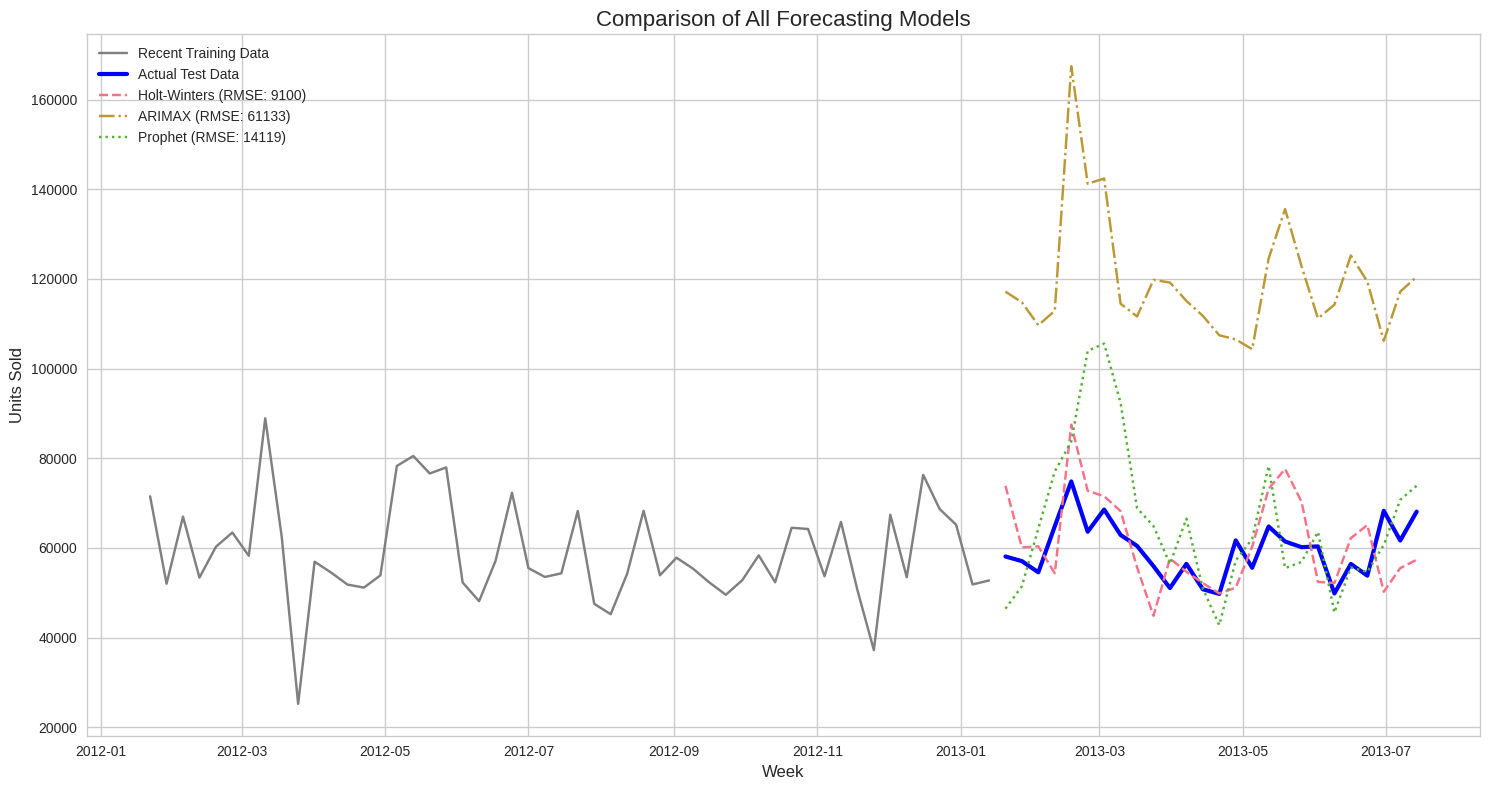


--- Workflow Complete ---


In [34]:
# ## 7. Final Results and Visualization (All Models Plotted)
# ------------------------------------------------------------------------------
print("\n--- Final Model Evaluation ---")
best_model_name = min(results, key=results.get)

print("\nModel Performance Comparison (RMSE):")
# Use .get() to handle both 'ARIMAX' and 'Auto-ARIMAX' names gracefully
for model, rmse in sorted(results.items(), key=lambda item: item[1]):
    print(f"- {model}: {rmse:.2f}")

print(f"\n🏆 The best performing model is: {best_model_name}")

# --- Visualize All Model Forecasts for Comparison ---
print("\nVisualizing forecasts from all models...")
plt.figure(figsize=(15, 8))

# To speed up the plot, show only the last 52 weeks of training data
plt.plot(train_data.tail(52).index, train_data.tail(52)['units_sold'], label='Recent Training Data', color='gray')

# Plot the actual test data
plt.plot(test_data.index, test_data['units_sold'], label='Actual Test Data', color='blue', linewidth=3)

# Plot forecasts from all models with their RMSE in the label
# Use different line styles to make them easy to distinguish
arimax_rmse = results.get('ARIMAX', results.get('Auto-ARIMAX')) # Get the correct RMSE value
plt.plot(test_data.index, hw_predictions, label=f"Holt-Winters (RMSE: {results['Holt-Winters']:.0f})", linestyle='--')
plt.plot(test_data.index, arima_predictions, label=f"ARIMAX (RMSE: {arimax_rmse:.0f})", linestyle='-.')
plt.plot(test_data.index, prophet_predictions_df['yhat'].values, label=f"Prophet (RMSE: {results['Prophet']:.0f})", linestyle=':')

# Formatting the plot
plt.title('Comparison of All Forecasting Models', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Workflow Complete ---")